# Conformal prediction with Flax and MAPIE

In [128]:
import jax.numpy as jnp
import jax.random as jr
import mapie
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import Array
from mapie.regression import MapieRegressor
from matplotlib.gridspec import GridSpec
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pbnn.map_estimation import train_fn
from pbnn.models import MLP
from pbnn.utils.analytical_functions import gramacy_function
from pbnn.utils.plot import plot_on_axis

%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


### Generate data

In [13]:
n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]
X, X_test = jnp.array(X), jnp.array(X_test)

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = gramacy_function(X, noise)
y_test = gramacy_function(X_test, noise_test)

### Define a neural network using Flax

Let's define a simple MLP network using `pbnn.models`. In order to be able to use `MAPIE`, we also need to define a scikit-learn-like regressors that has `fit` and `predict` methods.

Two regressors are implemented below: a simple MLP regressor trained with a MSE loss, and a MLP quantile regressor trained with the pinball loss.

In [110]:
class MLPRegressor(RegressorMixin, BaseEstimator):
    def __init__(
        self,
        hidden_features: int,
        output_features: int,
        batch_size: int = 32,
        num_epochs: int = 1000,
        lr: float = 5e-3,
        rng_key: Array = jr.PRNGKey(0),
    ):
        self.model = MLP(hidden_features=hidden_features, out_features=output_features)
        self.hidden_features = hidden_features
        self.output_features = output_features
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.rng_key = rng_key

    def fit(self, X, y):
        X, y = jnp.array(X), jnp.array(y)

        def loss_fn(params, batch_of_data):
            X_batch, y_batch = batch_of_data
            predictions = self.model.apply({"params": params}, X_batch).squeeze()
            return -optax.losses.l2_loss(predictions, y_batch).mean()

        self.params = train_fn(
            logposterior_fn=loss_fn,
            network=self.model,
            train_ds={"x": X, "y": y},
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            learning_rate=self.lr,
            rng_key=self.rng_key,
        )

        _, self.rng_key = jr.split(self.rng_key)

        return self

    def predict(self, X):
        X = jnp.array(X)
        return self.model.apply({"params": self.params}, X).squeeze()


class QuantileMLPRegressor(RegressorMixin, BaseEstimator):
    def __init__(
        self,
        hidden_features: int,
        output_features: int,
        alpha: float,
        batch_size: int = 32,
        num_epochs: int = 1000,
        lr: float = 5e-3,
        rng_key: Array = jr.PRNGKey(0),
    ):
        self.model = MLP(hidden_features=hidden_features, out_features=output_features)
        self.hidden_features = hidden_features
        self.output_features = output_features
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.alpha = alpha
        self.alpha_ = [alpha, 0.5, 1 - alpha]
        self.rng_key = rng_key

        assert output_features == len(self.alpha_)

    def fit(self, X, y):
        X, y = jnp.array(X), jnp.array(y)

        def loss_fn(params, batch_of_data):
            X, target = batch_of_data
            preds = self.model.apply({"params": params}, X)

            losses = []
            preds_reshape = preds.reshape((-1, target.shape[1], len(self.alpha_)))
            for i, q in enumerate(self.alpha_):
                errors = target - preds_reshape[..., i]
                losses.append(jnp.maximum((q - 1) * errors, q * errors))

            loss = jnp.mean(jnp.sum(jnp.concatenate(losses, axis=-1), axis=-1))
            return -loss

        self.params = train_fn(
            logposterior_fn=loss_fn,
            network=self.model,
            train_ds={"x": X, "y": y},
            batch_size=self.batch_size,
            num_epochs=self.num_epochs,
            learning_rate=self.lr,
            rng_key=self.rng_key,
        )

        _, self.rng_key = jr.split(self.rng_key)

        return self

    def predict(self, X):
        X = jnp.array(X)
        return self.model.apply({"params": self.params}, X).squeeze()

### Custom implementation of split CQR

Altough split conformalized quantile regression is available in `MAPIE`, it can't be used with an arbitrary quantile regressor. However, it can easily be implemented as follows.

In [108]:
from typing import Union

from sklearn.base import clone


class SplitCQR(object):
    def __init__(
        self,
        regressor,
        X_train: Union[list, np.ndarray],
        y_train: np.ndarray,
        X_cal: Union[list, np.ndarray],
        y_cal: np.ndarray,
        alpha: float,
    ) -> object:
        self.alpha = alpha

        self.X_train = X_train
        self.y_train = y_train

        self.X_cal = X_cal
        self.y_cal = y_cal

        self.output_dim = y_train.shape[1]
        self.regressor = clone(regressor)
        self.__class__.__name__ = "split_cqr"

    def fit(self):
        self.regressor.fit(self.X_train, self.y_train)
        pred_cal = self.regressor.predict(self.X_cal).reshape(-1, self.output_dim, 3)

        r_lo = pred_cal[:, :, 0] - self.y_cal
        r_hi = self.y_cal - pred_cal[:, :, 2]
        self.residuals = np.max(np.stack([r_lo, r_hi], axis=2), axis=2)
        return self

    def predict(self, X_test: np.ndarray):
        n = len(self.X_cal)

        pred_test = self.regressor.predict(X_test)
        q_med, q_lo, q_hi = pred_test[:, 1::3], pred_test[:, 0::3], pred_test[:, 2::3]

        qleft = np.empty((len(X_test), self.output_dim))
        qright = np.empty((len(X_test), self.output_dim))
        for k in range(self.output_dim):
            q = np.quantile(
                self.residuals[:, k],
                (1 - self.alpha) / (1.0 + 1.0 / n),
                axis=0,
                method="higher",
            )
            qleft[:, k] = q_lo[:, k] - q
            qright[:, k] = q_hi[:, k] + q
        return q_med, qleft, qright

### Apply conformal prediction using MAPIE

/data/users/bstaber/.conda/envs/jax-cipiu/lib/python3.11/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/data/users/bstaber/.conda/envs/jax-cipiu/lib/python3.11/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)


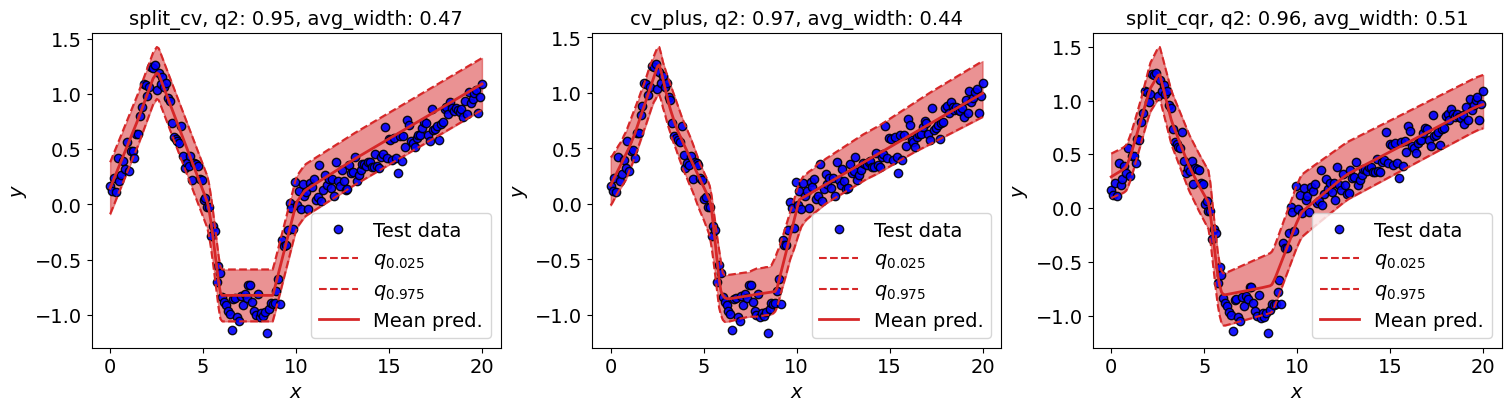

In [122]:
alpha = 0.1

algorithms = {
    "split_cv": dict(method="base", cv="split", test_size=0.1),
    "cv_plus": dict(method="plus", cv=20),
    "split_cqr": dict(test_size=0.2, alpha=alpha),
}

mlp_regressor_params = {
    "hidden_features": 100,
    "output_features": 1,
    "num_epochs": 1_000,
    "lr": 5e-3,
}

quantile_regressor_params = {
    "hidden_features": 100,
    "output_features": 3,
    "num_epochs": 1_000,
    "lr": 5e-3,
    "alpha": alpha,
}

fig = plt.figure(constrained_layout=True, figsize=(3 * 5, 1 * 4))
gs = GridSpec(nrows=1, ncols=3, figure=fig)

for i, (algorithm, params) in enumerate(algorithms.items()):
    if algorithm == "split_cqr":
        regressor = QuantileMLPRegressor(**quantile_regressor_params)
        X_train, X_cal, y_train, y_cal = train_test_split(
            X, y, test_size=params["test_size"]
        )
        model = SplitCQR(
            regressor, X_train, y_train, X_cal, y_cal, alpha=params["alpha"]
        )
        model.fit()
        y_pred, qlow, qhigh = model.predict(X_test)
    else:
        regressor = MLPRegressor(**mlp_regressor_params)
        mapie = MapieRegressor(
            regressor,
            **params,
        )
        mapie.fit(X, y.ravel())
        y_pred, y_pis = mapie.predict(X_test, alpha=alpha)
        qlow, qhigh = y_pis[:, 0, 0], y_pis[:, 1, 0]

    q2_score = r2_score(y_test, y_pred)
    avg_width = np.mean(qhigh - qlow)

    ax = fig.add_subplot(gs[i])
    plot_on_axis(
        ax,
        X_test,
        y_test,
        y_pred.ravel(),
        qlow.ravel(),
        qhigh.ravel(),
        title=f"{algorithm}, q2: {q2_score:.2f}, avg_width: {avg_width:.2f}",
    )

In [126]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Mon Mar 11 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

jax       : 0.4.23
matplotlib: 3.8.2
mapie     : 0.8.3
optax     : 0.1.9
flax      : 0.8.0
numpy     : 1.26.3

Watermark: 2.4.3

